# 速度抛掷测试
【完成】

In [7]:
from phi.torch.flow import *
import tqdm

In [8]:
def throw(x, vel, force, dt):
    vel_new = vel + force * dt
    x_new = x + vel_new * dt
    return x_new, vel_new

In [9]:
@jit_compile
def loss_function(x_target, x_init, vel_init, vel_dir, force_in, dt, steps):
    iter_x, iter_v = x_init, vel_init * vel_dir
    for _ in range(steps):
        iter_x, iter_v = throw(iter_x, iter_v, force_in, dt)
    loss = math.l2_loss(iter_x - x_target)
    return loss


grad_fun = math.gradient(loss_function, wrt='vel_init, vel_dir', get_output=False)

In [10]:
def gradient_descent_step(x_target, x_init, vel, vel_dir, force_in, dt, steps, learning_rate=.00001):
    d_vel, d_vel_dir = grad_fun(x_target, x_init, vel, vel_dir, force_in, dt, steps)
    return vel - learning_rate * d_vel, vel_dir - learning_rate * d_vel_dir

In [13]:
in_x_target = vec(x=114., y=514.)
in_x_init = vec(x=0., y=0.)
in_vel_init = 1.
in_vel_dir_init = vec(x=1., y=1.)
in_force_in = vec(x=0., y=-9.8)
in_dt = .1
in_steps = 100

train_vel = in_vel_init
train_vel_dir = in_vel_dir_init
train_vel_record = [train_vel]
train_vel_dir_record = [train_vel_dir]
for _ in tqdm.trange(100):
    train_vel, train_vel_dir = gradient_descent_step(in_x_target, in_x_init, train_vel, train_vel_dir, in_force_in,
                                                     in_dt, in_steps)
    train_vel_record.append(train_vel)
    train_vel_dir_record.append(train_vel_dir)

  0%|          | 0/100 [00:00<?, ?it/s]C:\Users\imeho\Documents\VituralEnvs\InstantPINF-TCNN\Lib\site-packages\phiml\math\_functional.py:628: RuntimeWarning: Using torch for gradient computation because numpy does not support jacobian()
  warnings.warn(f"Using {math.default_backend()} for gradient computation because {key.backend} does not support jacobian()", RuntimeWarning)
100%|██████████| 100/100 [00:00<00:00, 292.09it/s]


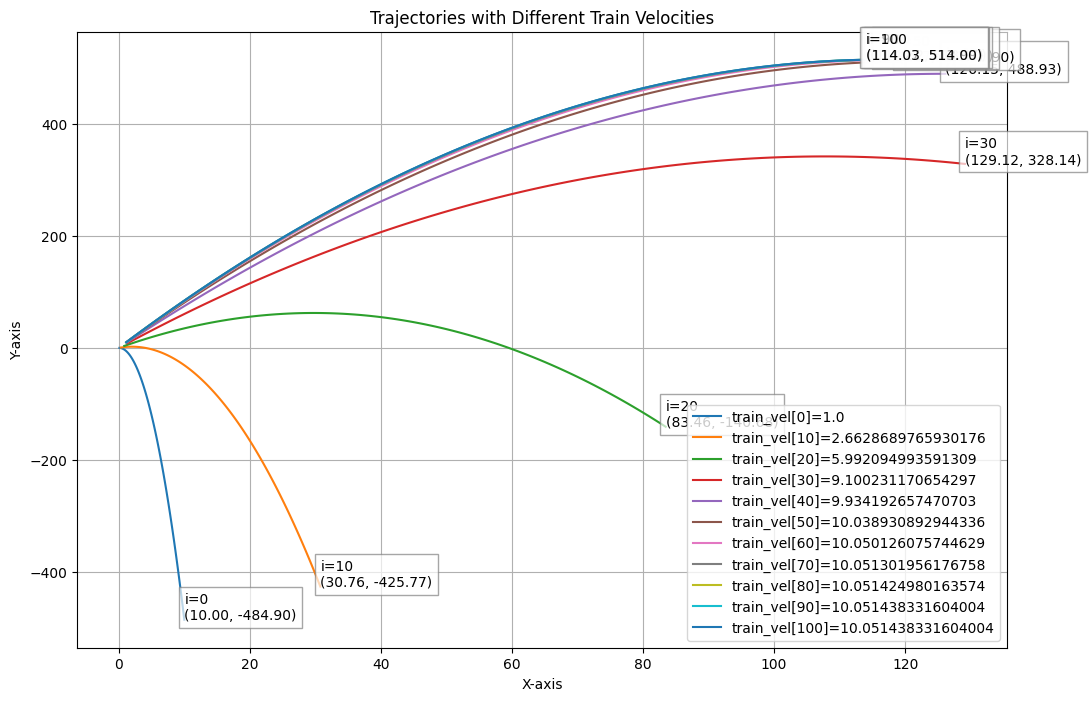

In [14]:
import matplotlib.pyplot as plt
from matplotlib import colormaps

# 开始绘图
plt.figure(figsize=(12, 8))

# 每隔10个train_vel绘制一条曲线
for idx, i in enumerate(range(0, len(train_vel_record), len(train_vel_record) // 10)):
    train_vel = train_vel_record[i]
    train_vel_dir = train_vel_dir_record[i]
    iter_x, iter_v = in_x_init, train_vel * train_vel_dir
    x_coords = []
    y_coords = []

    for _ in range(in_steps):
        iter_x, iter_v = throw(iter_x, iter_v, in_force_in, in_dt)
        x_coords.append(iter_x[0])
        y_coords.append(iter_x[1])

    # 为每条曲线添加到图中
    plt.plot(x_coords, y_coords, linestyle='-', label=f'train_vel[{i}]={train_vel}')

    # 在每条曲线的最后一个点标注当前的 i 以及 (x, y)
    last_x = x_coords[-1].native().item()
    last_y = y_coords[-1].native().item()
    plt.text(last_x, last_y, f'i={i}\n({last_x:.2f}, {last_y:.2f})', fontsize=10, color='black',
             bbox=dict(facecolor='white', alpha=0.7, edgecolor='gray'))

# 添加图例、标题等
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Trajectories with Different Train Velocities')
plt.legend()
plt.grid(True)
plt.show()